<a href="https://colab.research.google.com/github/ryu622/gnn-counterattack-xai-v2/blob/feat%2Fdelete-show-and-add-show2/GNN_CounterAttack_Thesis_show2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- 1. 環境設定と依存関係のインストール ---
# 必要なライブラリをすべてインストール
!pip install torch-scatter torch-sparse torch-geometric sklearn tqdm networkx matplotlib
!pip install torch-geometric

# Google Driveをマウント（ファイルアクセスに必須）
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader as PyGDataLoader
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.utils import dense_to_sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.calibration import calibration_curve
from tqdm import tqdm
import numpy as np
import pickle
import sys
import networkx as nx
import matplotlib.pyplot as plt
import os
import logging
import copy

# ロガー設定
logger = logging.getLogger(__name__)
if not logger.handlers:
    stdout_handler = logging.StreamHandler(sys.stdout)
    logger.addHandler(stdout_handler)

print("✅ STEP 1 完了: 環境設定と依存関係のインポートが完了しました。")

  Using cached torch_scatter-2.1.2.tar.gz (108 kB)
  Preparing metadata (setup.py) ... done
  Using cached torch_sparse-0.6.18.tar.gz (209 kB)
  Preparing metadata (setup.py) ... done
  Using cached torch_geometric-2.7.0-py3-none-any.whl.metadata (63 kB)
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Using cached torch_geometric-2.7.0-py3-none-any.whl.metadata (63 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.8 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibl

In [ ]:
# --- 2. データロード、特徴量定義、PyGデータセット変換 ---

# --- データロード ---
# --- 🚨 以下のファイルパスを正確に確認し、必要に応じて修正してください 🚨 ---
file_path = '/content/drive/MyDrive/GNN_Football_Analysis/Raw_Data/women.pkl'

try:
    with open(file_path, 'rb') as handle:
        og_data = pickle.load(handle)
    print(f"✅ データロード完了: ファイルパス {file_path}")
except FileNotFoundError:
    print(f"❌ 重大なエラー: ファイルパス '{file_path}' が見つかりません。パスを修正するか、ファイルをGoogle Driveにアップロードしてください。")
    sys.exit()

# --- 特徴量定義のためのウィジェット代替 ---
class Checkbox:
    def __init__(self, value, description): self.value = value
class MockDropdown:
    def __init__(self, value): self.value = value
class MockVBox:
    def __init__(self, children): self.children = children

adj_matrix = MockDropdown('normal')
edge_f_box = MockVBox([Checkbox(value=True, description='Player Distance')] * 6)
node_f_box = MockVBox([Checkbox(value=True, description='x coordinate')] * 12)

# --- 特徴量フィルタリング (正しい特徴量名で定義) ---
def filter_features(data, gender=None):
    CORRECT_NODE_FEATURES = [
        "X Coordinate", "Y Coordinate", "vX", "vY", "Speed", "Velocity Angle",
        "Distance to Goal", "Angle with Goal", "Distance to Ball", "Angle with Ball",
        "Time in Possession", "Is Ball Carrier"
    ]
    edge_feature_idxs = [idx for idx, x in enumerate(edge_f_box.children) if x.value]
    node_feature_idxs = [idx for idx, x in enumerate(node_f_box.children) if x.value]
    global node_features
    node_features = [CORRECT_NODE_FEATURES[i] for i in node_feature_idxs]
    mat_type = adj_matrix.value
    data[mat_type]['e'] = [x[:, edge_feature_idxs] for x in data[mat_type]['e']]
    data[mat_type]['x'] = [x[:, node_feature_idxs] for x in data[mat_type]['x']]
    return data

data = filter_features(og_data.copy())

# --- PyGデータセットクラスと変換 ---
class PyG_CounterDataset(Dataset):
    def __init__(self, data, matrix_type):
        self.raw_data = data; self.matrix_type = matrix_type
        self._data_list = self.process_data()
        super().__init__(None, None, None)
    def process_data(self):
        data_mat = self.raw_data[self.matrix_type]; data_list = []
        for x_np, a_np, e_np, y_np in tqdm(zip(data_mat['x'], data_mat['a'], data_mat['e'], self.raw_data['binary']), total=len(data_mat['x']), desc="Converting to PyG Data"):
            try:
                if x_np.shape[0] == 0: continue
                if hasattr(a_np, 'todense'): a_np = a_np.todense()
                x = torch.tensor(x_np, dtype=torch.float); a = torch.tensor(a_np, dtype=torch.float)
                y = torch.tensor(y_np, dtype=torch.float).view(-1, 1)
                edge_index, _ = dense_to_sparse(a)
                if edge_index.numel() == 0: continue
                data_list.append(Data(x=x, edge_index=edge_index, y=y))
            except Exception: continue
        return data_list
    def len(self): return len(self._data_list)
    def get(self, idx): return self._data_list[idx]

dataset_pyg = PyG_CounterDataset(data=data, matrix_type='normal')
print(f"✅ STEP 2 完了: PyTorch Geometricデータセットの変換完了。全サンプル数: {len(dataset_pyg)}")

✅ データロード完了: ファイルパス /content/drive/MyDrive/GNN_Football_Analysis/Raw_Data/women.pkl


Converting to PyG Data: 100%|██████████| 4348/4348 [00:00<00:00, 5729.69it/s]

✅ STEP 2 完了: PyTorch Geometricデータセットの変換完了。全サンプル数: 4348


In [ ]:
# --- 3. GATモデル、ハイパーパラメータ、関数の定義 ---

# --- ハイパーパラメータ ---
CHANNELS = 32; LAYERS = 3; ATTN_HEADS = 4; N_OUT = 1; LEARNING_RATE = 1e-3; EPOCHS = 50; BATCH_SIZE = 32

# --- GATモデルクラスの定義 (アテンション抽出機能付き) ---
class PyG_GNN_Attn(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, num_heads, out_channels):
        super(PyG_GNN_Attn, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads, dropout=0.5, concat=True)
        self.convs = nn.ModuleList([GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, dropout=0.5, concat=True) for _ in range(num_layers - 1)])
        self.conv_out = GATConv(hidden_channels * num_heads, hidden_channels, heads=1, dropout=0.5, concat=False)
        self.dense1 = nn.Linear(hidden_channels, hidden_channels); self.dense_out = nn.Linear(hidden_channels, out_channels)

    def forward(self, data, return_attn=False):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        attn_weights = None

        if return_attn: x, (edge_index, attn_weights) = self.conv1(x, edge_index, return_attention_weights=True)
        else: x = self.conv1(x, edge_index)

        x = F.elu(x);
        for conv in self.convs: x = F.elu(conv(x, edge_index))
        x = F.elu(self.conv_out(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.relu(self.dense1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        output = torch.sigmoid(self.dense_out(x))

        if return_attn: return output, edge_index, attn_weights.squeeze()
        return output

# --- 訓練/評価関数の定義 ---
def train_pyg(model, loader, optimizer, criterion):
    model.train(); total_loss = 0; device = next(model.parameters()).device
    for data in loader:
        data = data.to(device); optimizer.zero_grad(); out = model(data)
        loss = criterion(out, data.y); loss.backward(); optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def evaluate_pyg(model, loader):
    model.eval(); preds = []; labels = []; device = next(model.parameters()).device
    with torch.no_grad():
        for data in loader:
            data = data.to(device); out = model(data)
            preds.append(out.cpu().numpy().flatten()); labels.append(data.y.cpu().numpy().flatten())
    preds = np.concatenate(preds); labels = np.concatenate(labels)
    if len(np.unique(labels)) > 1: auc = roc_auc_score(labels, preds)
    else: auc = 0.0
    return auc, preds

print("✅ STEP 3 完了: モデルクラスと訓練/評価関数の定義が完了しました。")

✅ STEP 3 完了: モデルクラスと訓練/評価関数の定義が完了しました。


In [ ]:
# --- 4. DataLoaderの準備とモデルの訓練 ---

# データセット分割
final_data_list = dataset_pyg._data_list; indices = np.arange(len(final_data_list))
idx_tr, idx_te = train_test_split(indices, test_size=0.3, random_state=42) # 30%をテストに使用
dataset_tr_pyg = [final_data_list[i] for i in idx_tr]; dataset_te_pyg = [final_data_list[i] for i in idx_te]

loader_tr_pyg = PyGDataLoader(dataset_tr_pyg, batch_size=BATCH_SIZE, shuffle=True)
loader_te_pyg_clean = PyGDataLoader(dataset_te_pyg, batch_size=BATCH_SIZE, shuffle=False)

# モデルのインスタンス化
model_attn = PyG_GNN_Attn(in_channels=dataset_pyg.num_node_features, hidden_channels=CHANNELS, num_layers=LAYERS, num_heads=ATTN_HEADS, out_channels=N_OUT)
optimizer_pyg = torch.optim.Adam(model_attn.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()

# 訓練の実行
print("\n🚀 PyTorch GATモデルの訓練を開始します...")
for epoch in range(1, EPOCHS + 1):
    loss = train_pyg(model_attn, loader_tr_pyg, optimizer_pyg, criterion)
    if epoch % 10 == 0: print(f"--- Epoch {epoch}/{EPOCHS} --- Loss: {loss:.4f}")
    print(f"--- Epoch {epoch}/{EPOCHS} --- Training Loss: {loss:.4f}")
print("✅ STEP 4 完了: 訓練が完了しました。")


🚀 PyTorch GATモデルの訓練を開始します...
--- Epoch 1/50 --- Training Loss: 0.6862
--- Epoch 2/50 --- Training Loss: 0.6683
--- Epoch 3/50 --- Training Loss: 0.6536
--- Epoch 4/50 --- Training Loss: 0.6505
--- Epoch 5/50 --- Training Loss: 0.6438
--- Epoch 6/50 --- Training Loss: 0.6460
--- Epoch 7/50 --- Training Loss: 0.6432
--- Epoch 8/50 --- Training Loss: 0.6418
--- Epoch 9/50 --- Training Loss: 0.6353
--- Epoch 10/50 --- Loss: 0.6402
--- Epoch 10/50 --- Training Loss: 0.6402
--- Epoch 11/50 --- Training Loss: 0.6353
--- Epoch 12/50 --- Training Loss: 0.6306
--- Epoch 13/50 --- Training Loss: 0.6297
--- Epoch 14/50 --- Training Loss: 0.6322
--- Epoch 15/50 --- Training Loss: 0.6323
--- Epoch 16/50 --- Training Loss: 0.6287
--- Epoch 17/50 --- Training Loss: 0.6279
--- Epoch 18/50 --- Training Loss: 0.6289
--- Epoch 19/50 --- Training Loss: 0.6296
--- Epoch 20/50 --- Loss: 0.6271
--- Epoch 20/50 --- Training Loss: 0.6271
--- Epoch 21/50 --- Training Loss: 0.6299
--- Epoch 22/50 --- Training Lo


--- 最終テスト結果 --- AUC: 0.7106

🧠 PFI (パーミュテーション特徴量重要度) の計算を開始します...

--- 特徴量重要度 (AUC低下量) ---
[Angle with Goal     ] : 0.04212
[Distance to Goal    ] : 0.04016
[vX                  ] : 0.03653
[vY                  ] : 0.03485
[X Coordinate        ] : 0.03003
[Y Coordinate        ] : 0.01607
[Is Ball Carrier     ] : 0.01115
[Speed               ] : 0.01007
[Angle with Ball     ] : 0.00906
[Time in Possession  ] : 0.00320
[Distance to Ball    ] : 0.00140
[Velocity Angle      ] : 0.00017


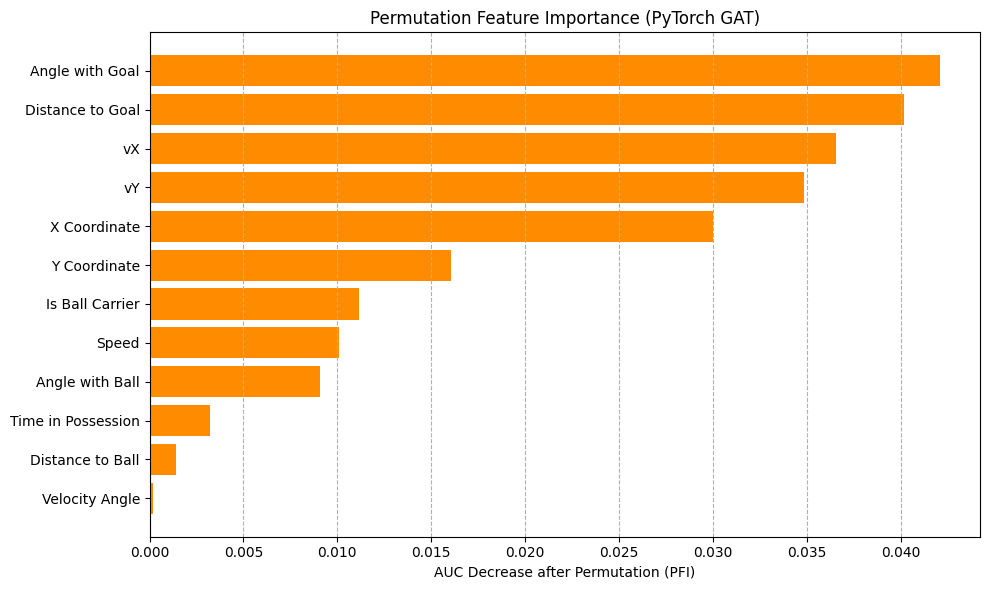

✅ STEP 5 完了: PFIの計算と可視化が完了しました。


In [ ]:
# --- 5. 最終評価とPFIの計算 ---

# 評価の実行
auc_te, preds_te = evaluate_pyg(model_attn, loader_te_pyg_clean)
labels_te = np.concatenate([data.y.numpy().flatten() for data in dataset_te_pyg])

print(f"\n--- 最終テスト結果 --- AUC: {auc_te:.4f}")

# PFIの関数定義
def calculate_permutation_importance(model, loader, features_list, n_repeats=3):
    """テストデータセット上で、各特徴量のパーミュテーション重要度 (AUCの低下) を計算する"""
    auc, _ = evaluate_pyg(model, loader)
    baseline_auc = auc; importance = {}

    for idx, feature_name in enumerate(features_list):
        auc_decreases = []
        for _ in range(n_repeats):
            permuted_data_list = [];
            for batch_data in loader:
                x_permuted = batch_data.x.clone()
                perm_indices = torch.randperm(x_permuted.size(0))
                x_permuted[:, idx] = x_permuted[perm_indices, idx]
                permuted_batch = batch_data.clone(); permuted_batch.x = x_permuted
                permuted_data_list.append(permuted_batch)

            permuted_loader = PyGDataLoader(permuted_data_list, batch_size=loader.batch_size, shuffle=False)
            permuted_auc, _ = evaluate_pyg(model, permuted_loader)
            auc_decreases.append(baseline_auc - permuted_auc)

        importance[feature_name] = np.mean(auc_decreases)
    return importance

# PFIの実行 (計算時間を考慮し、ここではn_repeats=3で実行)
print("\n🧠 PFI (パーミュテーション特徴量重要度) の計算を開始します...")
importance_results = calculate_permutation_importance(model_attn, loader_te_pyg_clean, node_features, n_repeats=3)

# PFI結果の可視化
sorted_importance = sorted(importance_results.items(), key=lambda item: item[1], reverse=True)
print("\n--- 特徴量重要度 (AUC低下量) ---")
for feature, decrease in sorted_importance:
    print(f"[{feature: <20}] : {decrease:.5f}")

features = [item[0] for item in sorted_importance]; decreases = [item[1] for item in sorted_importance]
plt.figure(figsize=(10, 6)); plt.barh(features, decreases, color='darkorange')
plt.xlabel('AUC Decrease after Permutation (PFI)'); plt.title('Permutation Feature Importance (PyTorch GAT)')
plt.gca().invert_yaxis(); plt.grid(axis='x', linestyle='--'); plt.tight_layout(); plt.show()
print("✅ STEP 5 完了: PFIの計算と可視化が完了しました。")

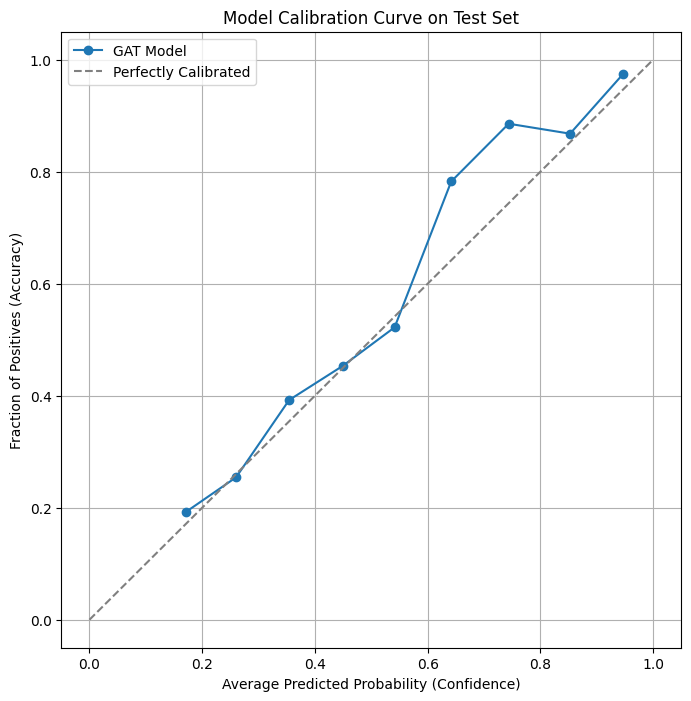

✅ STEP 6 完了: キャリブレーション曲線の描画が完了しました。


In [ ]:
# --- 6. キャリブレーション（較正）曲線の描画 ---

prob_true, prob_pred = calibration_curve(y_true=labels_te, y_prob=preds_te, n_bins=10, strategy='uniform')

plt.figure(figsize=(8, 8))
plt.plot(prob_pred, prob_true, marker='o', label='GAT Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

plt.xlabel("Average Predicted Probability (Confidence)"); plt.ylabel("Fraction of Positives (Accuracy)")
plt.title("Model Calibration Curve on Test Set")
plt.legend(); plt.grid(True); plt.show()

print("✅ STEP 6 完了: キャリブレーション曲線の描画が完了しました。")

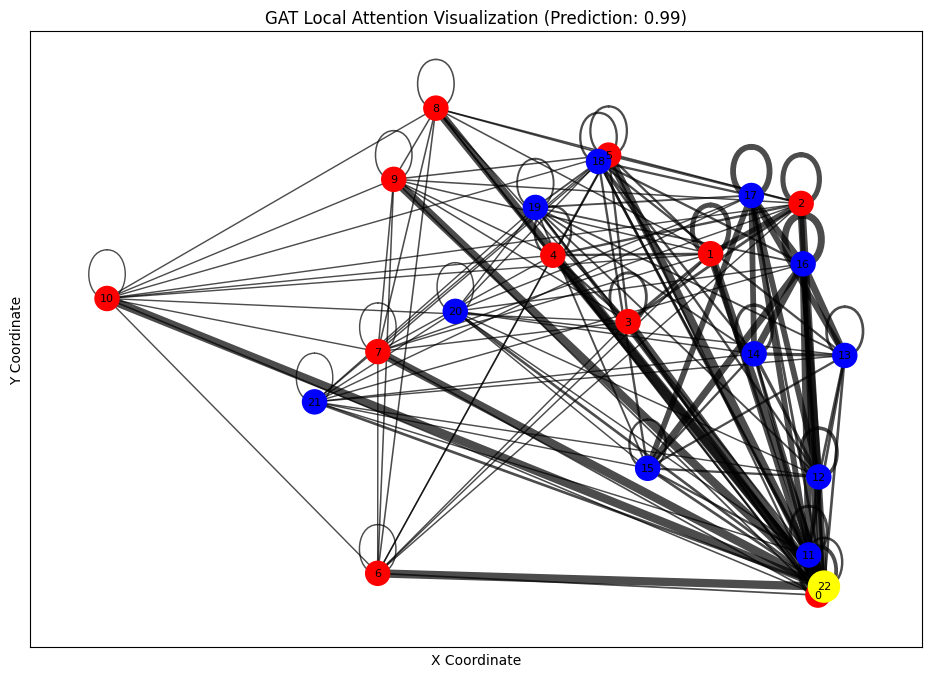

🏁 STEP 7 完了: すべての工程が完了しました。


In [ ]:
# --- 7. アテンション係数の可視化 ---

# 1. 成功予測フレームの特定
model_attn.eval(); max_pred = -1.0; best_index = 0
device = next(model_attn.parameters()).device
with torch.no_grad():
    for idx, data_frame in enumerate(dataset_te_pyg):
        data_frame = data_frame.to(device)
        prediction_prob = model_attn(data_frame).item()
        if prediction_prob > max_pred: max_pred = prediction_prob; best_index = idx

# 2. アテンションの抽出
single_frame = dataset_te_pyg[best_index]; single_data = single_frame.to(device)
with torch.no_grad():
    prediction, edge_index_attn, weights_attn = model_attn(single_data, return_attn=True)

# 3. NetworkXグラフの構築
x_coords = single_data.x[:, 0].cpu().numpy(); y_coords = single_data.x[:, 1].cpu().numpy()
edge_list = edge_index_attn.cpu().numpy().T; attention_weights = weights_attn.cpu().numpy()
G = nx.Graph(); num_nodes = len(x_coords); G.add_nodes_from(range(num_nodes)); pos = {i: (x_coords[i], y_coords[i]) for i in range(num_nodes)}
min_w = attention_weights.min(); max_w = attention_weights.max()
normalized_weights_np = 10 * (attention_weights - min_w) / (max_w - min_w + 1e-6) + 1

for i, (u, v) in enumerate(edge_list):
    try: weight_val = float(normalized_weights_np[i].flatten()[0])
    except Exception: weight_val = float(normalized_weights_np[i])
    G.add_edge(u, v, weight=weight_val)

# 4. 可視化の実行
plt.figure(figsize=(12, 8)); plt.title(f"GAT Local Attention Visualization (Prediction: {prediction.item():.2f})")
num_players = 22; num_players_per_team = 11
node_colors = ['red'] * num_players_per_team + ['blue'] * num_players_per_team + ['yellow']
node_sizes = [300] * num_players + [500]
edge_widths = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, label=True)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.7, edge_color='black')
nx.draw_networkx_labels(G, pos, font_size=8)
plt.gca().set_aspect('equal', adjustable='box'); plt.xlabel("X Coordinate"); plt.ylabel("Y Coordinate"); plt.show()

print("🏁 STEP 7 完了: すべての工程が完了しました。")

In [ ]:
# --- 1. 最も高い予測確率を持つフレームの特定 ---
model_attn.eval()
max_pred = -1.0
best_index = -1
device = next(model_attn.parameters()).device

with torch.no_grad():
    for idx, data_frame in enumerate(dataset_te_pyg):
        # モデルと同じデバイスに移動
        data_frame = data_frame.to(device)

        # 予測確率の取得
        prediction_prob = model_attn(data_frame).item()

        if prediction_prob > max_pred:
            max_pred = prediction_prob
            best_index = idx

print(f"✅ 最も高い予測確率 {max_pred:.4f} を持つフレームのインデックス: {best_index}")

✅ 最も高い予測確率 0.9889 を持つフレームのインデックス: 162


In [ ]:
# --- 2. 特定フレームのアテンション抽出とグラフの再構築（基本データ生成） ---

# 成功フレームのデータ取得
single_frame = dataset_te_pyg[best_index]
single_data = single_frame.to(next(model_attn.parameters()).device)

# アテンション値の抽出
with torch.no_grad():
    prediction, edge_index_attn, weights_attn = model_attn(single_data, return_attn=True)

print(f"予測確率: {prediction.item():.2f}")

# 3. NetworkXグラフの構築
x_coords = single_data.x[:, 0].cpu().numpy()
y_coords = single_data.x[:, 1].cpu().numpy()
edge_list = edge_index_attn.cpu().numpy().T
attention_weights = weights_attn.cpu().numpy()

G = nx.Graph()
num_nodes = len(x_coords)
G.add_nodes_from(range(num_nodes))
pos = {i: (x_coords[i], y_coords[i]) for i in range(num_nodes)}

# エッジの重み付けと正規化
min_w = attention_weights.min()
max_w = attention_weights.max()
# normalized_weights が以降のフィルタリングに使用されます
normalized_weights = 10 * (attention_weights - min_w) / (max_w - min_w + 1e-6) + 1

for i, (u, v) in enumerate(edge_list):
    try:
        # NumPyの型をPythonのfloatに変換するロジック
        weight_val = float(normalized_weights[i].flatten()[0])
    except Exception:
        weight_val = float(normalized_weights[i])

    G.add_edge(u, v, weight=weight_val)

# ノード定義 (グラフ全体で共通)
num_players = 22
num_players_per_team = 11
node_colors = ['red'] * num_players_per_team + ['blue'] * num_players_per_team + ['yellow']
node_sizes = [300] * num_players + [500]

予測確率: 0.99


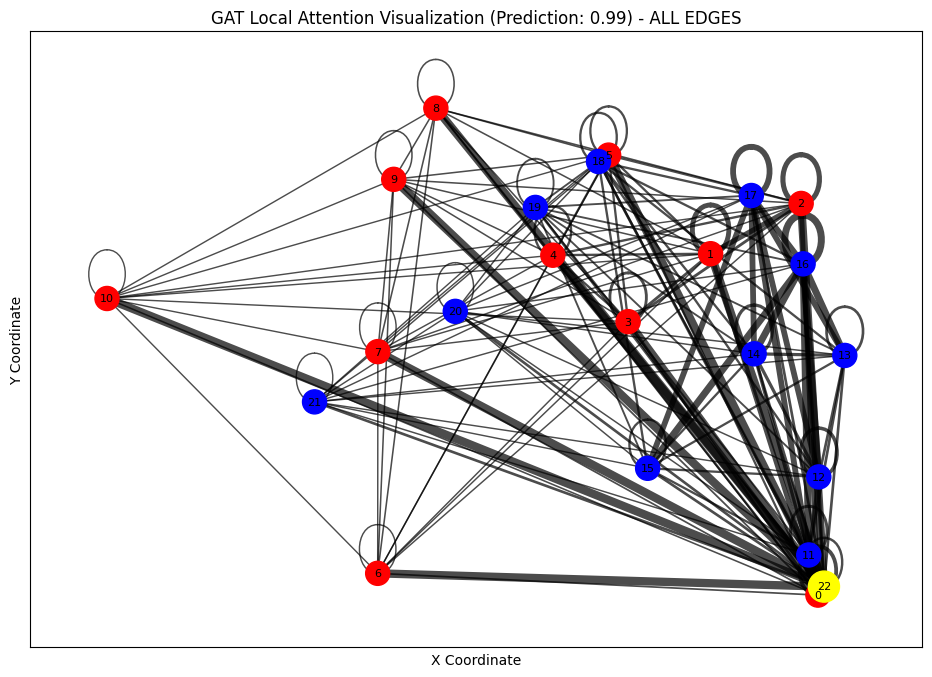

✅ 全体のアテンション可視化が完了しました。


In [ ]:
# --- 3. 全体のアテンション可視化 ---

edge_widths = [G[u][v]['weight'] for u, v in G.edges()]

plt.figure(figsize=(12, 8))
plt.title(f"GAT Local Attention Visualization (Prediction: {prediction.item():.2f}) - ALL EDGES")

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, label=True)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.7, edge_color='black')
nx.draw_networkx_labels(G, pos, font_size=8)

plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

print("✅ 全体のアテンション可視化が完了しました。")

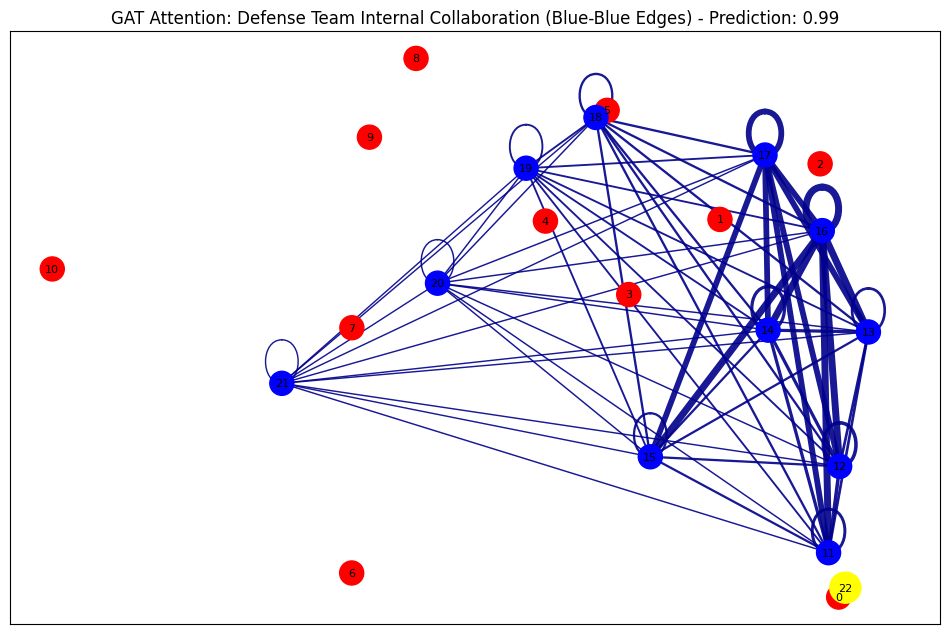

✅ 守備側のみの連携グラフ描画が完了しました。


In [ ]:
# --- 4. 守備側のみの内部連携 (Blue-Blue) 可視化 ---

DEFENSE_START_ID = 11
DEFENSE_END_ID = 21

defense_edges = []
defense_widths = []

# Gに格納された重みを参照し、守備-守備のエッジのみをフィルタリング
for u, v, data in G.edges(data=True):
    is_defense_u = (DEFENSE_START_ID <= u <= DEFENSE_END_ID)
    is_defense_v = (DEFENSE_START_ID <= v <= DEFENSE_END_ID)

    if is_defense_u and is_defense_v:
        defense_edges.append((u, v))
        defense_widths.append(data['weight'])

# グラフの描画
plt.figure(figsize=(12, 8))
plt.title(f"GAT Attention: Defense Team Internal Collaboration (Blue-Blue Edges) - Prediction: {prediction.item():.2f}")

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, label=True)
nx.draw_networkx_edges(G, pos, edgelist=defense_edges, width=defense_widths, alpha=0.9, edge_color='darkblue')
nx.draw_networkx_labels(G, pos, font_size=8)

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

print("✅ 守備側のみの連携グラフ描画が完了しました。")

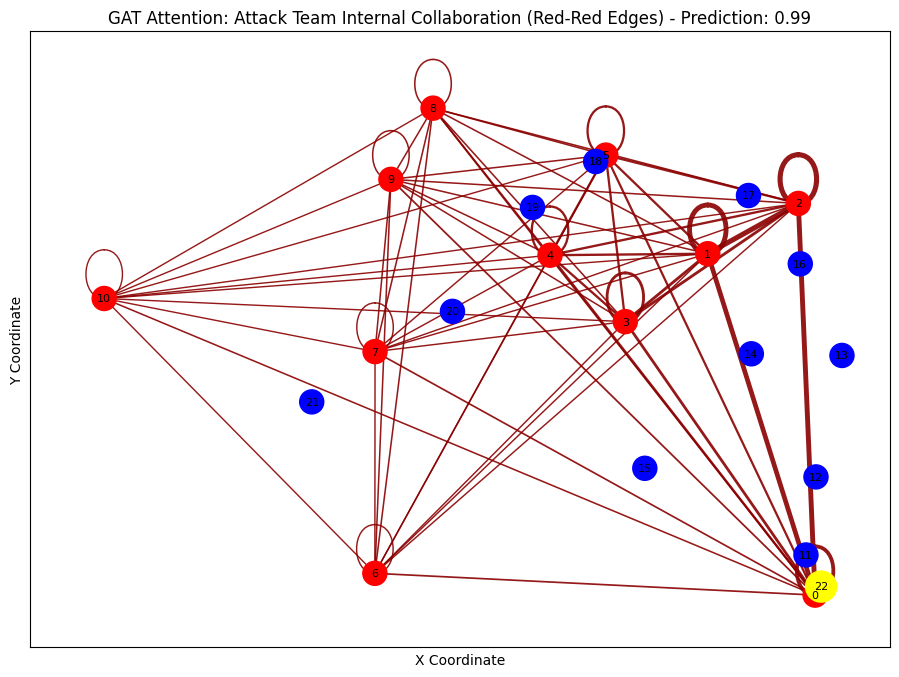

✅ 攻撃側のみの連携グラフ描画が完了しました。


In [ ]:
# --- 5. 攻撃側のみの内部連携 (Red-Red) 可視化 ---

ATTACK_START_ID = 0
ATTACK_END_ID = 10

attack_edges = []
attack_widths = []

# Gに格納された重みを参照し、攻撃-攻撃のエッジのみをフィルタリング
for u, v, data in G.edges(data=True):
    is_attack_u = (ATTACK_START_ID <= u <= ATTACK_END_ID)
    is_attack_v = (ATTACK_START_ID <= v <= ATTACK_END_ID)

    if is_attack_u and is_attack_v:
        attack_edges.append((u, v))
        attack_widths.append(data['weight'])

# グラフの描画
plt.figure(figsize=(12, 8))
plt.title(f"GAT Attention: Attack Team Internal Collaboration (Red-Red Edges) - Prediction: {prediction.item():.2f}")

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, label=True)
nx.draw_networkx_edges(G, pos, edgelist=attack_edges, width=attack_widths, alpha=0.9, edge_color='darkred')
nx.draw_networkx_labels(G, pos, font_size=8)

plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

print("✅ 攻撃側のみの連携グラフ描画が完了しました。")

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch

# --- 1. 失敗予測フレーム（確率が最小）を見つける ---
model_attn.eval()
min_pred = 2.0  # 予測確率の初期値を最大値よりも大きく設定 (シグモイド出力は0から1)
best_index_failure = -1
device = next(model_attn.parameters()).device

with torch.no_grad():
    for idx, data_frame in enumerate(dataset_te_pyg):
        data_frame = data_frame.to(device)
        prediction_prob = model_attn(data_frame).item()

        # 予測確率が現在の最小値 (min_pred) よりも低い場合、更新する
        if prediction_prob < min_pred:
            min_pred = prediction_prob
            best_index_failure = idx

print(f"✅ 最も低い予測確率 {min_pred:.4f} を持つ失敗フレームのインデックス: {best_index_failure}")

# --- 2. NetworkXグラフの構築 ---

# 失敗フレームのデータ取得
single_frame = dataset_te_pyg[best_index_failure]
single_data = single_frame.to(device)

# アテンション値の抽出
with torch.no_grad():
    prediction, edge_index_attn, weights_attn = model_attn(single_data, return_attn=True)

print(f"失敗予測確率: {prediction.item():.2f}")

# テンソルをCPU上のNumPy配列に変換
x_coords = single_data.x[:, 0].cpu().numpy()
y_coords = single_data.x[:, 1].cpu().numpy()
edge_list = edge_index_attn.cpu().numpy().T
attention_weights = weights_attn.cpu().numpy()

# NetworkXグラフの構築
G = nx.Graph()
num_nodes = len(x_coords)
G.add_nodes_from(range(num_nodes))
pos = {i: (x_coords[i], y_coords[i]) for i in range(num_nodes)}

# エッジの重み付けと正規化
min_w = attention_weights.min()
max_w = attention_weights.max()
normalized_weights_np = 10 * (attention_weights - min_w) / (max_w - min_w + 1e-6) + 1

# グラフにエッジと重みを追加 (型変換ロジックを維持)
for i, (u, v) in enumerate(edge_list):
    try:
        weight_val = float(np.float64(normalized_weights_np[i]))
    except Exception:
        weight_val = float(normalized_weights_np[i].flatten()[0])
    G.add_edge(u, v, weight=weight_val)

# ノード情報 (描画共通)
num_players = 22
num_players_per_team = 11
node_colors = ['red'] * num_players_per_team + ['blue'] * num_players_per_team + ['yellow']
node_sizes = [300] * num_players + [500]

✅ 最も低い予測確率 0.1044 を持つ失敗フレームのインデックス: 1014
失敗予測確率: 0.10


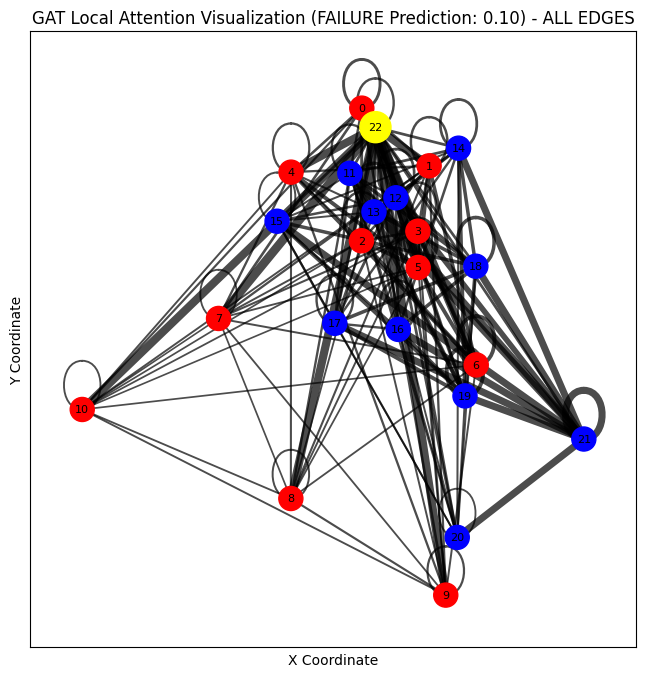

✅ 失敗フレーム全体のアテンション可視化が完了しました。


In [ ]:
# --- 2. 失敗フレーム全体のアテンション可視化 ---

edge_widths = [G[u][v]['weight'] for u, v in G.edges()]

plt.figure(figsize=(12, 8))
plt.title(f"GAT Local Attention Visualization (FAILURE Prediction: {prediction.item():.2f}) - ALL EDGES")

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, label=True)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.7, edge_color='black')
nx.draw_networkx_labels(G, pos, font_size=8)

plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

print("✅ 失敗フレーム全体のアテンション可視化が完了しました。")

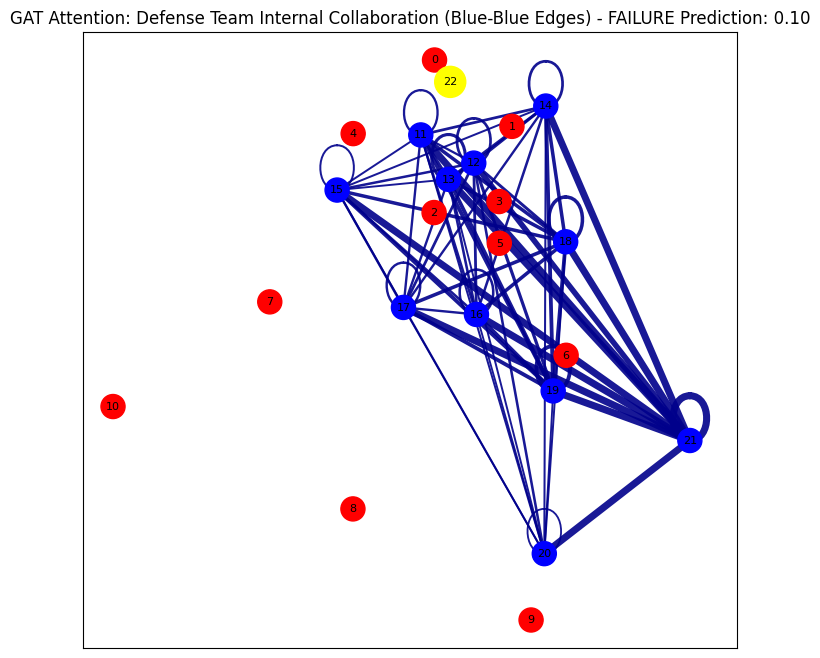

✅ 失敗フレーム守備側のみの連携グラフ描画が完了しました。


In [ ]:
# --- 3. 失敗フレーム守備側のみの内部連携 (Blue-Blue) 可視化 ---

DEFENSE_START_ID = 11
DEFENSE_END_ID = 21

defense_edges = []
defense_widths = []

for u, v, data in G.edges(data=True):
    is_defense_u = (DEFENSE_START_ID <= u <= DEFENSE_END_ID)
    is_defense_v = (DEFENSE_START_ID <= v <= DEFENSE_END_ID)

    if is_defense_u and is_defense_v:
        defense_edges.append((u, v))
        defense_widths.append(data['weight'])

plt.figure(figsize=(12, 8))
plt.title(f"GAT Attention: Defense Team Internal Collaboration (Blue-Blue Edges) - FAILURE Prediction: {prediction.item():.2f}")

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, label=True)
nx.draw_networkx_edges(G, pos, edgelist=defense_edges, width=defense_widths, alpha=0.9, edge_color='darkblue')
nx.draw_networkx_labels(G, pos, font_size=8)

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

print("✅ 失敗フレーム守備側のみの連携グラフ描画が完了しました。")

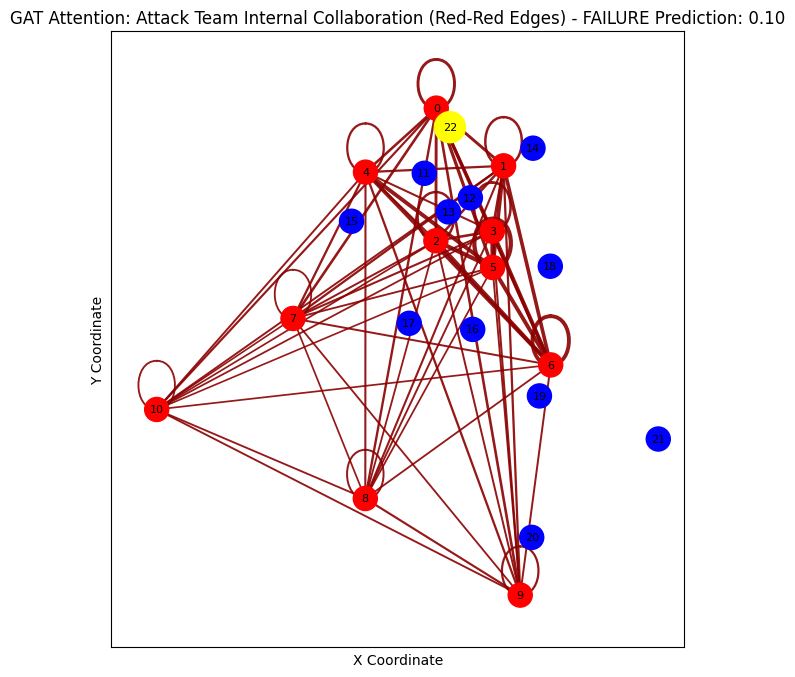

✅ 失敗フレーム攻撃側のみの連携グラフ描画が完了しました。


In [ ]:
# --- 4. 失敗フレーム攻撃側のみの内部連携 (Red-Red) 可視化 ---

ATTACK_START_ID = 0
ATTACK_END_ID = 10

attack_edges = []
attack_widths = []

for u, v, data in G.edges(data=True):
    is_attack_u = (ATTACK_START_ID <= u <= ATTACK_END_ID)
    is_attack_v = (ATTACK_START_ID <= v <= ATTACK_END_ID)

    if is_attack_u and is_attack_v:
        attack_edges.append((u, v))
        attack_widths.append(data['weight'])

plt.figure(figsize=(12, 8))
plt.title(f"GAT Attention: Attack Team Internal Collaboration (Red-Red Edges) - FAILURE Prediction: {prediction.item():.2f}")

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, label=True)
nx.draw_networkx_edges(G, pos, edgelist=attack_edges, width=attack_widths, alpha=0.9, edge_color='darkred')
nx.draw_networkx_labels(G, pos, font_size=8)

plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

print("✅ 失敗フレーム攻撃側のみの連携グラフ描画が完了しました。")